# Demo sheet for comparing RF Kernel GP bases with Gaussian bases.

In our paper we utilise a set of bassis functions that allow us to approximate a GP with an RBF Kernel:
\begin{equation}
\phi_m(x) = \sqrt{\frac{2\tau^2}{M}} \cos( \frac{1}{\lambda}w_m^\top x+b_m).
\end{equation}
These bases struggle with single point source approximations and also with negative values in cases where (one would hope) no negative values emerge.
In this demo I try using gaussian basis so that 
\begin{equation}
\phi_m(x) = \frac{1}{\tau\sqrt{2\pi}}\exp\left(-\frac{1}{2\lambda^2}(x-\mu_m)^2\right)
\end{equation}
in the 1D case and
\begin{equation}
\phi_m(x) = \prod_{i=1}^3\frac{1}{\tau\sqrt{2\pi}}\exp\left(-\frac{1}{2\lambda_i^2}(x_i-\mu_{mi})^2\right)
\end{equation}
in the 3D case.
Hopefully, as these bases are always positive, it is easier for the system to achieve non-negative outputs.

These bases have been simply included in the code and can be activated using a "compact=True" command in the computeSourceFromPhi and ComputeModelRegressors functions (needs to be done in both). 

# Second Order ODE Example

In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models import AdjointSecondOrderODEModel as Model #Model module builds basic parts of the ODE problem, combines other classes into full model

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointSecondOrderODEModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.kernels import GaussianBases #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [2]:
avg=0.0001 # time that an observation is taken for
tlocL = np.linspace(0,9.99,200) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time
X[:,1] = X[:,0]+avg # upper time

In [3]:
k_0 = -0.5 #Diffusion coefficient
u=1
eta=5
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(0.6, 1.0) # generate EQ kernel arguments are lengthscale and variance
res = [200] # grid size for time

In [4]:
sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)

# Standard Problem Demo

In [5]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #initiate PDE model to build concentration

dt,dt2,Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGTSP=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
concTrainSP=m.computeConcentration(sourceGTSP) # Compute concentration - runs ODE forward model
#concTrain[concTrain<0]=0
#m.concentration=concTrain
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

In [6]:
#%%timeit
N_feat =1000 #Number of features used to infer the source
kInverse = EQ(0.6, 1) # Initiate kernel for inverse problem
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInferSP = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInferSP=mInfer.computeConcentration(sourceInferSP) # Generates estimated concentration from inferred source

Getting Grid Step Size
Building X matrix
Calculating Adjoints...
199/200 
Calculating Phis...
999/1000 
Calculating SS
Inverting SS
Computing meanZ
Done


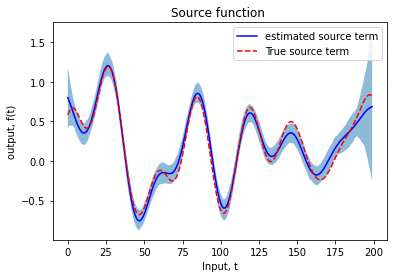

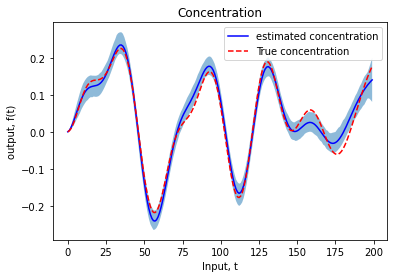

In [7]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInferSP,'b-')
plt.plot(xtest,sourceGTSP,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInferSP,'b-')
plt.plot(xtest,concTrainSP,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

In [8]:
#%%timeit
N_feat =1000 #Number of features used to infer the source
kInverse = GaussianBases(0.6, 1) # Initiate kernel for inverse problem
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInferCSP = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInferCSP=mInfer.computeConcentration(sourceInferCSP) # Generates estimated concentration from inferred source


Getting Grid Step Size
Building X matrix
Calculating Adjoints...
199/200 
Calculating Phis...
999/1000 
Calculating SS
Inverting SS
Computing meanZ
Done


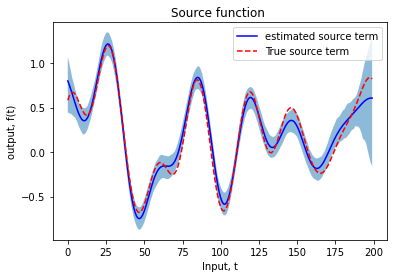

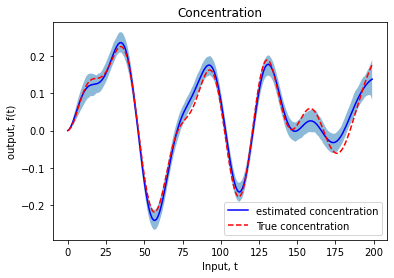

In [9]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInferCSP,'b-')
plt.plot(xtest,sourceGTSP,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInferCSP,'b-')
plt.plot(xtest,concTrainSP,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

# Diffuse point source demo

In [10]:
z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
x = np.linspace(0,10,200)
sourceGTGP=np.exp(-(1/1)*(x-1)**2)
concTrainGP=m.computeConcentration(sourceGTGP) # Compute concentration - runs ODE forward model
#concTrain[concTrain<0]=0
#m.concentration=concTrain
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

# Original Model

In [11]:
#%%timeit
N_feat =1000 #Number of features used to infer the source
kInverse = EQ(0.6, 1) # Initiate kernel for inverse problem
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInferGP = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInferGP=mInfer.computeConcentration(sourceInferGP) # Generates estimated concentration from inferred source

Getting Grid Step Size
Building X matrix
Calculating Adjoints...
199/200 
Calculating Phis...
999/1000 
Calculating SS
Inverting SS
Computing meanZ
Done


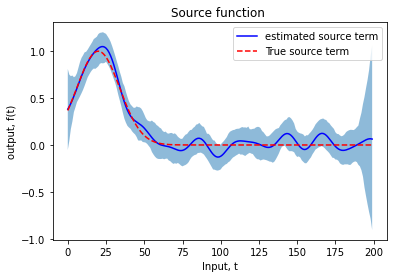

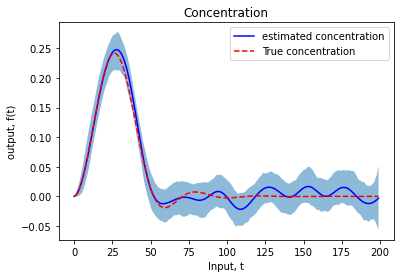

In [12]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInferGP,'b-')
plt.plot(xtest,sourceGTGP,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInferGP,'b-')
plt.plot(xtest,concTrainGP,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

# Gaussian Basis Model

In [13]:
#%%timeit
N_feat =1000 #Number of features used to infer the source
kInverse = GaussianBases(0.6, 1) # Initiate kernel for inverse problem
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInferCGP = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInferCGP=mInfer.computeConcentration(sourceInferCGP) # Generates estimated concentration from inferred source

Getting Grid Step Size
Building X matrix
Calculating Adjoints...
199/200 
Calculating Phis...
999/1000 
Calculating SS
Inverting SS
Computing meanZ
Done


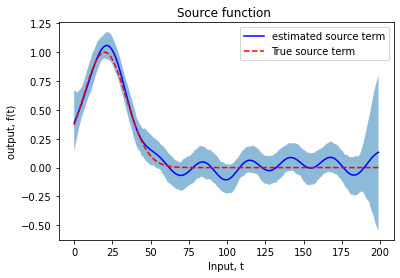

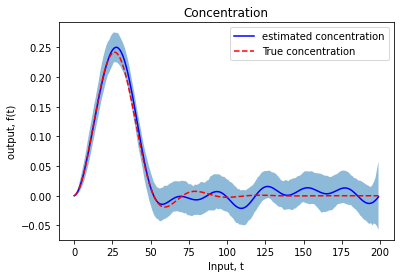

In [14]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInferCGP,'b-')
plt.plot(xtest,sourceGTGP,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInferCGP,'b-')
plt.plot(xtest,concTrainGP,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

# Inference quality

## Standard problem

Standard Model MSE (source and conc)

In [15]:
print(np.mean((concTrainSP-concInferSP)**2),np.mean((sourceGTSP-sourceInferSP)**2))

0.00034906034137728136 0.007098063992426013


Compact Model MSE (source and conc)

In [16]:
print(np.mean((concTrainSP-concInferCSP)**2),np.mean((sourceGTSP-sourceInferCSP)**2))

0.0003529884281894881 0.00801067224115305


## Diffuse point source

Standard Model MSE (source and conc)

In [17]:
print(np.mean((concTrainGP-concInferGP)**2),np.mean((sourceGTGP-sourceInferGP)**2))

9.131440261022002e-05 0.0031012130356255336


Compact Model MSE (source and conc)

In [18]:
print(np.mean((concTrainGP-concInferCGP)**2),np.mean((sourceGTGP-sourceInferCGP)**2))

8.655683238488063e-05 0.0026939886292039615


# Advection Diffusion Example with diffuse point source

In [19]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP

from advectionGP.models import AdjointAdvectionDiffusionModel as PDEModel

from advectionGP.wind import WindSimple#Wind model


from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.kernels import GaussianBases #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [20]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,10) # lower time
xloc=np.linspace(1,9,5) # x locations
yloc=np.linspace(1,9,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.1) # establish sensor model arguments are sensor locations and spatial averaging

In [21]:
k_0 = 0.01 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,50,50] # grid size for time, x and y


u1 = 0.1
u2 = 0.1
windmodel=WindSimple(u1,u2) # establish fixed wind model
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

#sourceGT=(m.computeSourceFromPhi(z))# Compute source

sourceGT = np.zeros(m.resolution)
x = np.linspace(0,10,50)
y = np.linspace(0,10,50)
Gco=np.asarray(np.meshgrid(x,y,indexing='ij'))
sourceGT[:,0:50,0:50]=np.exp(-(1/1)*(Gco[0]-5)**2)*np.exp(-(1/1)*(Gco[1]-5)**2)

In [22]:
boundary[1][0]

10

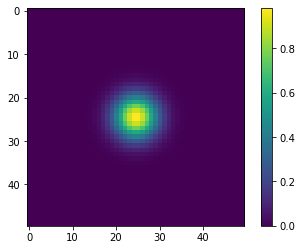

In [23]:
plt.imshow(sourceGT[0])
plt.colorbar()

In [24]:
m.sensormodel=sensors
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

In [25]:
N_feat =1000 #Number of features used to infer the source
k1 = EQ(1, 1.0) 
k2 = GaussianBases(0.5, 2.0) 

mInfer = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
regressInfer = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio
concInfer = mInfer.computeConcentration(sourceInfer)

yOut = mInfer.computeObservations()

Calculating Adjoints...
249/250 
Calculating Phis...
999/1000 
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing Source from Phi...


In [26]:
k2 = GaussianBases(0.5, 1.0) 

mInfer = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k2,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference

regressInfer = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInferC = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio
concInferC = mInfer.computeConcentration(sourceInferC)
yOut = mInfer.computeObservations()

Calculating Adjoints...
249/250 
Calculating Phis...
999/1000 
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing Source from Phi...


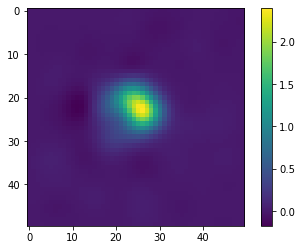

In [27]:
plt.imshow(concInferC[10])
plt.colorbar()

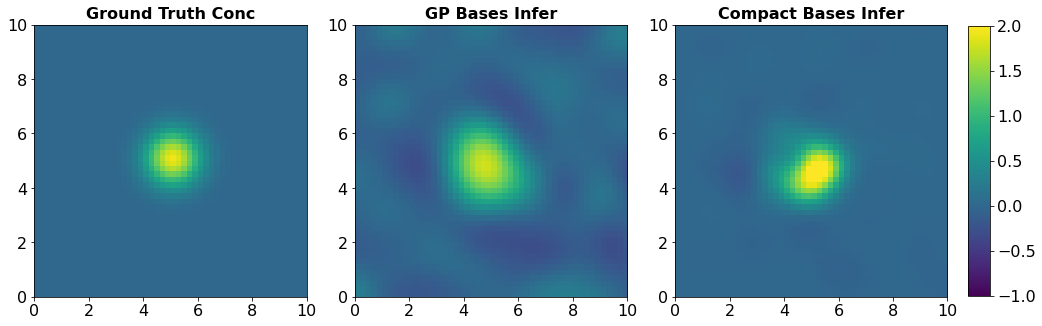

In [28]:
a=np.floor(np.min((np.min(concInfer[10]))))
b=np.ceil(np.max((np.max(concTrain[10]))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Conc','GP Bases Infer', 'Compact Bases Infer'],[concTrain, concInfer, concInferC]):
    ploti+=1
    plt.subplot(1,3,ploti)
    im1=plt.imshow(data[10], extent=[0,10,0,10],origin='lower') #fix t...
    #time = t*dt
    #plt.xlabel("t=%d" % time,fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.clim(a,b)


    tick_font_size = 16
    plt.title(title, fontsize=16, fontweight='bold')
    #if ploti % 3 == 3:
    #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

# 1D advection diffusion example with diffuse gaussian source

In [29]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP

from advectionGP.models import AdjointAdvectionDiffusion1DModel as Model

from advectionGP.wind import WindSimple#Wind model


from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.kernels import GaussianBases #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [30]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,10) # lower time
xloc=np.linspace(1,9,5) # x locations
sensN = len(xloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,3)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc)).reshape(2,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc)).reshape(2,sensN*obsN)[1] # x location
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.1) # establish sensor model arguments are sensor locations and spatial averaging

In [31]:
k_0 = 0.01 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0],[10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,50] # grid size for time, x and y


u1 = 0.1
u2 = 0.1
windmodel=WindSimple(u1,u2) # establish fixed wind model
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #initiate PDE model to build concentration

dt,dx,dx2,Nt,Nx = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

sourceGT=(m.computeSourceFromPhi(z))# Compute source

sourceGT = np.zeros(m.resolution)
x = np.linspace(0,10,50)

sourceGT[:,0:50]=np.exp(-(1/1)*(x-5)**2)

Computing Source from Phi...


In [32]:
m.sensormodel=sensors
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

In [33]:
N_feat =1000 #Number of features used to infer the source
k1 = EQ(0.5, 1.0) 
k2 = EQ(1, 2.0) 

mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
regressInfer = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio
concInfer = mInfer.computeConcentration(sourceInfer)

yOut = mInfer.computeObservations()

Calculating Adjoints...
49/50 
Calculating Phis...
999/1000 
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing Source from Phi...


In [34]:
N_feat =1000 #Number of features used to infer the source
k1 = GaussianBases(0.5, 1.0) 
k2 = EQ(1, 2.0) 

mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
regressInfer = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInferG = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio
concInferG = mInfer.computeConcentration(sourceInferG)

yOut = mInfer.computeObservations()

Calculating Adjoints...
49/50 
Calculating Phis...
999/1000 
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing Source from Phi...


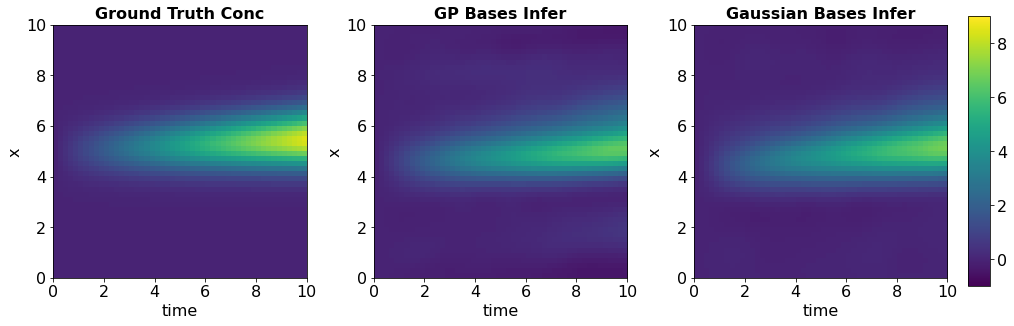

In [35]:
a=np.floor(np.min((np.min(concInfer))))
b=np.ceil(np.max((np.max(concTrain))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Conc','GP Bases Infer', 'Gaussian Bases Infer'],[concTrain.T, concInfer.T, concInferG.T]):
    ploti+=1
    plt.subplot(1,3,ploti)
    im1=plt.imshow(data, extent=[0,10,0,10],origin='lower') #fix t...
    #time = t*dt
    plt.xlabel("time",fontsize=16)
    plt.ylabel("x",fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.clim(a,b)


    tick_font_size = 16
    plt.title(title, fontsize=16, fontweight='bold')
    #if ploti % 3 == 3:
    #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()